# exploratory data analysis<a id='3_Exploratory_Data_Analysis'></a>

## contents
* [introduction](#introduction)
* [imports and load](#imports_and_load)
* [exploration](#exploration_start)
    - [check for bias](#bias_check)
        - [bias in race](#race)
        - [type of diabetes](#type)
    - [demographic visualizations](#demo_viz)
    - [demographic readmit ratios](#demo_rat)
    - [admission source and type](#admit_st)
    - [preadmission measurements](#preadmit_metrics)
        - [previous encounters](#prev_enc)
        - [glucose measurements](#glu_meas)
    - [numerical descriptions of admission](#num_)
        - [time in hopsital](#tih)
        - [number of lab procedures](#nlp)
        - [number of procedures](#np)
        - [number of medications](#nm)
        - [number of diagnoses](#nd)

## introduction<a id='introduction'></a>

The goal of this analysis will be to understand this data more fully.  This exploration will inform modelling decisions and possibly reveal insights itself.  This work will include reviewing distributions, scaling, encoding and testing interactions.  Additional data may be merged during exploration as needed and available.

## imports and load<a id='imports_and_load'></a>

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import chi2_contingency
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import OneHotEncoder
import warnings 
import ydata_profiling
import feather

warnings.filterwarnings('ignore')
%matplotlib inline

Pip requirements for reproducibility

In [2]:
pip list --format=freeze > requirements-nb2.txt

Note: you may need to restart the kernel to use updated packages.


Start with the output of the data wrangling and confirm load

In [3]:
admissions = feather.read_dataframe('../data/interim/notebook1_output.feather')
print(admissions.shape)
admissions.head(3)


(101727, 38)


,patient_nbr,race,gender,age,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,num_lab_procedures,num_procedures,...,pioglitazone,rosiglitazone,acarbose,miglitol,tolazamide,insulin,glyburide-metformin,change,diabetesMed,readmitted
encounter_id,,,,,,,,,,,,,,,,,,,,,
2278392,8222157,Caucasian,Female,[0-10),Other,Other,physicial referral,1,41,0,...,No,No,No,No,No,No,No,No,No,NO
149190,55629189,Caucasian,Female,[10-20),emergency,home,emergency room,3,59,0,...,No,No,No,No,No,Up,No,Ch,Yes,>30
64410,86047875,AfricanAmerican,Female,[20-30),emergency,home,emergency room,2,11,5,...,No,No,No,No,No,No,No,No,Yes,NO


In [4]:
admissions.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 101727 entries, 2278392 to 443867222
Data columns (total 38 columns):
 #   Column                    Non-Null Count   Dtype   
---  ------                    --------------   -----   
 0   patient_nbr               101727 non-null  int64   
 1   race                      101727 non-null  object  
 2   gender                    101727 non-null  object  
 3   age                       101727 non-null  category
 4   admission_type_id         101727 non-null  category
 5   discharge_disposition_id  101727 non-null  category
 6   admission_source_id       101727 non-null  category
 7   time_in_hospital          101727 non-null  int64   
 8   num_lab_procedures        101727 non-null  int64   
 9   num_procedures            101727 non-null  int64   
 10  num_medications           101727 non-null  int64   
 11  number_outpatient         101727 non-null  int64   
 12  number_emergency          101727 non-null  int64   
 13  number_inpatient    

## exploration<a id='exploration_start'></a>

### check for bias<a id='bias_check'></a>

#### race<a id='race'></a>

As there are demographics present, there is an opportunity to know if any particular group is over or under represented.  Race alone is the first target.  The 2000 [US Census](https://www2.census.gov/library/publications/decennial/2000/briefs/c2kbr01-01.pdf) reports a full population racial mix of 75.1% white and 12.3% black.

The American Diabetes Association [ADA](https://diabetes.org/about-us/statistics/about-diabetes#:~:text=Diabetes%20by%20race%2Fethnicity&text=12.1%25%20of%20non%2DHispanic%20blacks,7.4%25%20of%20non%2DHispanic%20whites) reports that 12.1% of  non-hispanic blacks and 7.4% of non-hispanic whites have diabetes diagnoses.  Ethnicity was not captured in this dataset so cannot be tested.




In [5]:
print('unique race values:', admissions.race.unique())
twoRace = admissions[admissions.race != 'Other'].copy()
twoRace_counts = twoRace.race.value_counts()
twoRace_fractions = twoRace.race.value_counts('normalize=True')

adj_white_count = twoRace_counts['Caucasian'] * 7.4
adj_black_count = twoRace_counts['AfricanAmerican'] * 12.1
adj_total = adj_white_count + adj_black_count
adj_white_perc = adj_white_count / adj_total
adj_black_perc = adj_black_count / adj_total
print('expected white fraction:', adj_white_perc)
print('observed white fraction:', twoRace_fractions['Caucasian'])
print('expected black fraction:', adj_black_perc)
print('observed black fraction:', twoRace_fractions['AfricanAmerican'])

unique race values: ['Caucasian' 'AfricanAmerican' 'Other']
expected white fraction: 0.7078017567818881
observed white fraction: 0.798421378564756
expected black fraction: 0.29219824321811194
observed black fraction: 0.201578621435244


To make this dataset unbiased, observations with a race value of "Caucasian" should make up ~71% of all observations.  The number of observations over that can be removed at random.

In [6]:
np.random.seed(42)
count_black = twoRace.race.value_counts()['AfricanAmerican']
count_white = twoRace.race.value_counts()['Caucasian']
white_to_remove = int(count_white - (count_black / 0.29 - count_black ))
raceWhite = twoRace[twoRace['race'] == 'Caucasian']
raceWhite = raceWhite.sample(raceWhite.shape[0] - white_to_remove)
raceBlack = twoRace[twoRace['race'] == 'AfricanAmerican']
twoRace = pd.concat( [raceBlack, raceWhite])
twoRace.race.value_counts('normalize=True')

Caucasian          0.710004
AfricanAmerican    0.289996
Name: race, dtype: float64

#### type of diabetes<a id='type'></a>

From here, statistics vary widely on prevalance of type 1 and type 2 diabetes by gender and age.  In general, males are more likely to have diabetes than females, but the gap between the sexes is smaller for type 1.  This dataset does contain the first 3 diagnoses for each admission.  Both ICD9 and ICD10 diagnoses codes are used.  ICD9 codes for diabetes start with 250 and ICD10 codes for type 1 start with E10 and type 2 start with E11.

In [7]:
twoRace[~(twoRace['diag_1'].str.contains('250')) &
        ~(twoRace['diag_1'].str.contains('E1')) &
        ~(twoRace['diag_2'].str.contains('250')) & 
        ~(twoRace['diag_2'].str.contains('E1')) &
        ~(twoRace['diag_3'].str.contains('250')) & 
        ~(twoRace['diag_3'].str.contains('E1')) 
       ].shape[0] / twoRace.shape[0] 

0.6218346545866364

Unfortunately, 62% of the observations here don't have any diabetes type diagnoses codes included.  Demographic bias corrections end here.

### demographic visualization <a id='demo_viz'></a>

<Figure size 640x480 with 0 Axes>

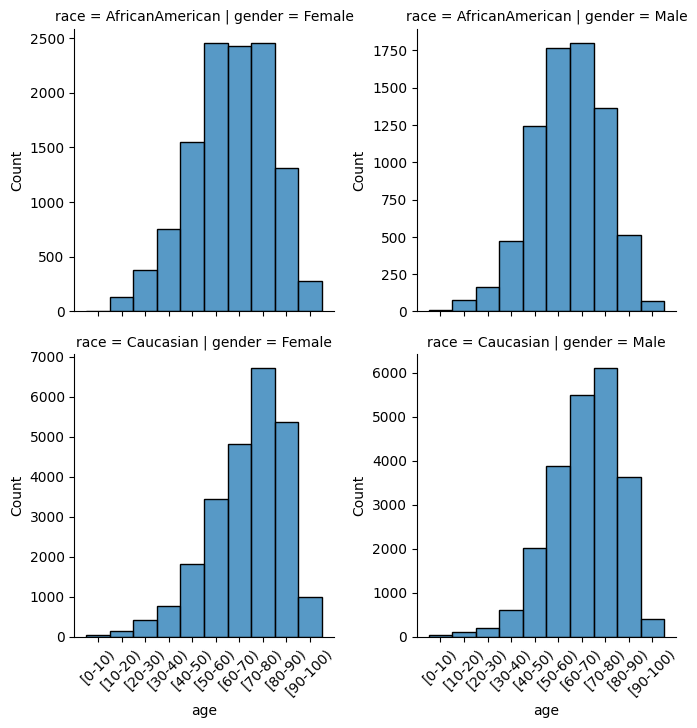

In [8]:
twoRace['age'] = pd.Categorical(twoRace['age'], ['[0-10)', '[10-20)', '[20-30)', '[30-40)', 
    '[40-50)', '[50-60)', '[60-70)', '[70-80)', '[80-90)', '[90-100)',])

plt.clf()

g = sns.FacetGrid(
    twoRace,
    col='gender',
    row='race',
    height=3.5,
    sharey=False
).map(sns.histplot, 'age')

for axes in g.axes.flat:
    for label in axes.get_xticklabels():
        label.set_rotation(45)

plt.show()

These distributions show that the various demographic combinations remaining in the dataset are well represented.  How are these combinations related to the readmission variable?  For this, I'll only be concerned with whether or not readmission happened and not whether or not in happened within 30 days.  I'll look at the readmit rate for each race, gender, age group combination.

<Figure size 640x480 with 0 Axes>

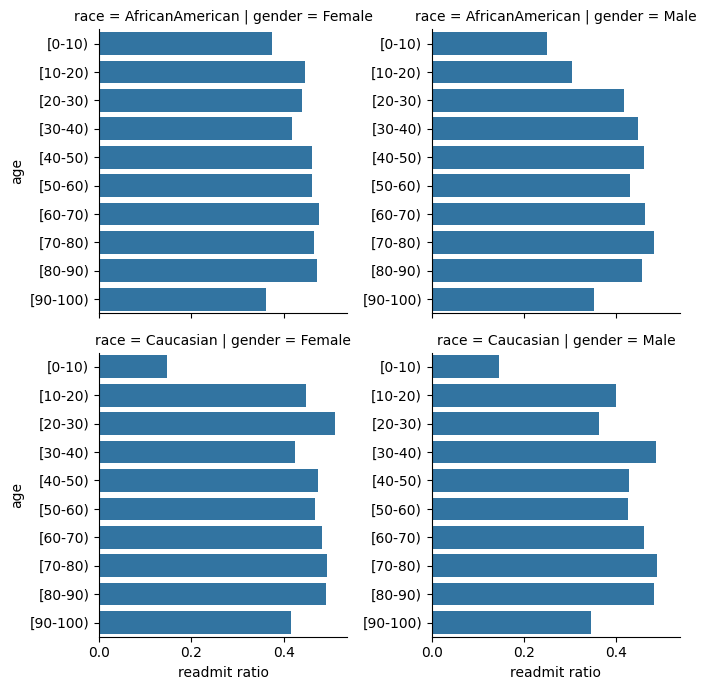

In [9]:
readmitMapping = {'NO': 0, '>30': 1, '<30': 1}
twoRace['readmitBinary'] = twoRace['readmitted'].replace(to_replace=readmitMapping)
demographic_readmit_mean = twoRace.groupby(['race','age','gender'])\
                           .agg([np.mean])['readmitBinary']\
                           .reset_index()

plt.clf()
g = sns.FacetGrid(
    demographic_readmit_mean,
    col='gender',
    row='race',
    height=3.5,
    sharey=False
).map(sns.barplot, 'mean', 'age')

[axes.set_xlabel('readmit ratio') for axes in g.axes.flat]

plt.show()

### demographic readmit ratios <a id='demo_rat'></a>

There are 2 notable items here.  
1. The 0-10 age group is very different between races
3. The 90-100 group has a lower ratio than most other age groups for each race/gender combination.

I suspect both of these can be explained with a small sample size

In [10]:
demographic_counts = twoRace.groupby(['age'])['patient_nbr'].count()
demographic_counts = demographic_counts.to_frame().reset_index()
demographic_counts[(demographic_counts['age'] == '[0-10)') | 
                   (demographic_counts['age'] == '[90-100)')]

,age,patient_nbr
0,[0-10),98
9,[90-100),1735


The small sample idea does hold for the 0-10 age group, but not the 90-100.  Its possible that the 90-100 age group expires during the admission more often than the others.  

In [11]:
twoRace['discharge_disposition_id'].unique()

['home', 'snf', 'Other', 'home health']
Categories (4, object): ['home', 'Other', 'snf', 'home health']

Expiration would fit into the 'Other' category, but so would transferred, etc.  Being discharged to a skilled nursing facility (SNF) or home health could also explain the lack of readmission as these would help with adherence to medical advice given at discharge.

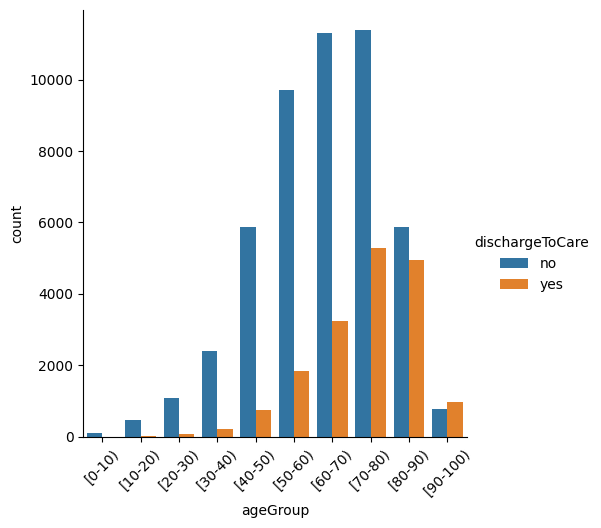

In [12]:
discharge_age_counts = twoRace.groupby(['age','discharge_disposition_id'])['patient_nbr'].count()
discharge_age_counts = discharge_age_counts.to_frame().reset_index()

discharge_age_counts.columns = ['ageGroup','dischargeToCare','count']
to_replace = {'Other': 'no', 'home': 'no', 'home health': 'yes', 'snf': 'yes'}
discharge_age_counts['dischargeToCare'] = discharge_age_counts['dischargeToCare'].replace(to_replace)
discharge_age_counts = discharge_age_counts.groupby(['ageGroup','dischargeToCare'])['count'].sum()
discharge_age_counts = discharge_age_counts.to_frame().reset_index()

_ = sns.catplot(data=discharge_age_counts
    , x='ageGroup' 
    , y='count' 
    , hue='dischargeToCare'
    , kind='bar'
)
plt.xticks(rotation=45)

plt.show()

The 90-100 age group is the only one where a patient is discharged to care more often than not.  The ratio of discharged to care vs not also increases with age after 30.  What does that look like?

<AxesSubplot: xlabel='ageGroup', ylabel='value'>

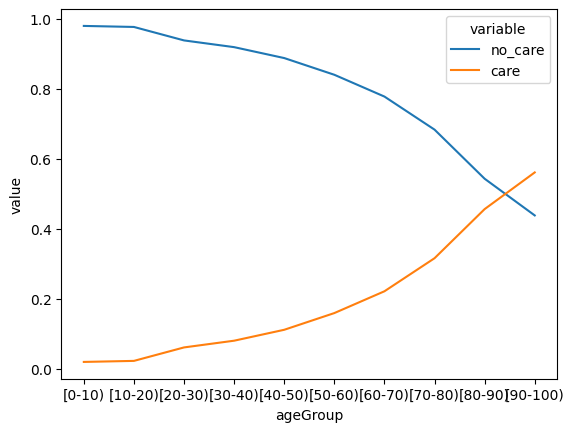

In [13]:
ratios = discharge_age_counts['count'] / \
         discharge_age_counts.groupby('ageGroup')['count'].transform('sum')
no_care = ratios[::2].to_frame().reset_index().drop(columns='index')
care = ratios[1::2].to_frame().reset_index().drop(columns='index')

age_ratios = pd.concat([no_care, care], axis=1)
age_ratios.columns=['no_care', 'care']
age_ratios['ageGroup'] = discharge_age_counts['ageGroup'].unique()

sns.lineplot(data=pd.melt(age_ratios, ['ageGroup']), x='ageGroup', y='value', hue='variable')


This is looking like a good candidate for a new feature.  Does it have a relationship to readmitted?

In [14]:
twoRace['DischargedToCare'] = twoRace['discharge_disposition_id'].replace(to_replace)

In [15]:
def chi2pvalue (rows, columns):
    contingency = pd.crosstab(rows, columns)
    _, p, _, _ = chi2_contingency(contingency)
    return p
    

In [16]:
chi2pvalue(twoRace.readmitted, twoRace.DischargedToCare)

9.39262946259018e-72

It does and this new feature will replace the discharge_disposition_id

In [17]:
twoRace = twoRace.drop(['discharge_disposition_id'], axis=1)

### admission source and type <a id='admit_st'></a>

These variables seem potentially redundant.  I will take a look at the frequency of combinations of their values.

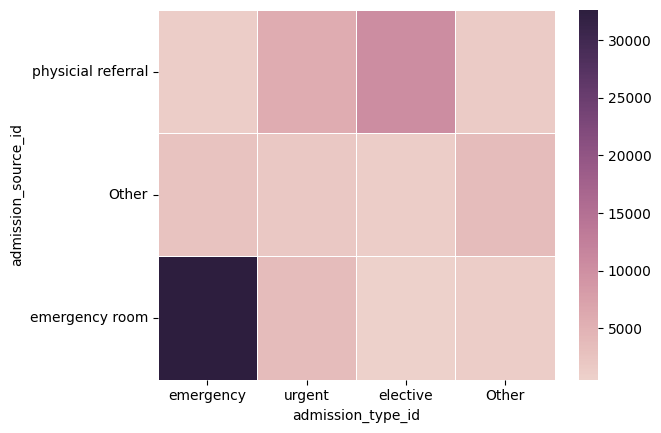

In [18]:
crosstab = pd.crosstab(twoRace['admission_source_id'], twoRace['admission_type_id'])
sns.heatmap(crosstab, cmap=sns.cubehelix_palette(as_cmap=True), yticklabels=True, linewidths=0.5)
plt.yticks(rotation=0)
plt.show()

The first item that stands out is that physical referral should be physician referral

In [19]:
twoRace['admission_source_id'] = twoRace['admission_source_id'].cat.rename_categories({'physicial referral': 'physician referral'})
twoRace.admission_source_id.unique()

['emergency room', 'Other', 'physician referral']
Categories (3, object): ['physician referral', 'Other', 'emergency room']

The next item that stands out is that these 2 look to have a strong association and are possibly redundant.  

In [20]:
chi2pvalue(twoRace.admission_source_id, twoRace.admission_type_id)

0.0

Because they are so closely related, I will compare simple logisitic regression models run with the readmitted binary variable and each of these variables independently as well as together to judge the value.  First, I need to encode them.

In [21]:
twoRace.admission_type_id = twoRace.admission_type_id.astype('category')
twoRace.admission_source_id = twoRace.admission_source_id.astype('category')

AdmissionFeatureSelection = twoRace[['admission_type_id','admission_source_id','readmitBinary']].copy()

encoder = OneHotEncoder(drop='first')
encoded = encoder.fit_transform(AdmissionFeatureSelection[['admission_type_id','admission_source_id']])

afs_encoded = pd.DataFrame(encoded.toarray(), columns=encoder.get_feature_names_out())
afs_encoded['readmitBinary'] = AdmissionFeatureSelection['readmitBinary'].values
afs_encoded

,admission_type_id_elective,admission_type_id_emergency,admission_type_id_urgent,admission_source_id_emergency room,admission_source_id_physician referral,readmitBinary
0,0.0,1.0,0.0,1.0,0.0,0
1,0.0,1.0,0.0,1.0,0.0,1
2,0.0,0.0,1.0,0.0,0.0,1
3,1.0,0.0,0.0,0.0,0.0,1
4,0.0,1.0,0.0,1.0,0.0,0
...,...,...,...,...,...,...
66220,0.0,0.0,0.0,0.0,0.0,1
66221,0.0,1.0,0.0,1.0,0.0,0
66222,0.0,0.0,1.0,1.0,0.0,0
66223,0.0,0.0,1.0,0.0,1.0,0


Then create a function to do the regression and return a single metric. 

In [22]:
def simple_logreg (x, y):
    
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=42)

    logreg = LogisticRegression()
    logreg.fit(x_train, y_train)
    y_pred = logreg.predict(x_test)

    label_and_weight = dict(zip(x.columns, logreg.coef_[0]))

    return accuracy_score(y_test, y_pred), label_and_weight

In [23]:
y = afs_encoded.readmitBinary

admission_type_x = afs_encoded.loc[:, afs_encoded.columns.str.contains('type')]
print(admission_type_x.shape)
simple_logreg(admission_type_x, y)

(66225, 3)


(0.5302289062028145,
 {'admission_type_id_elective': -0.34208973434550477,
  'admission_type_id_emergency': -0.07997740548052237,
  'admission_type_id_urgent': -0.11144173362381758})

In [24]:
admission_source_x = afs_encoded.loc[:, afs_encoded.columns.str.contains('source')]
print(admission_source_x.shape)
simple_logreg(admission_source_x, y)

(66225, 2)


(0.5302289062028145,
 {'admission_source_id_emergency room': 0.4017572686906928,
  'admission_source_id_physician referral': 0.16698493594568195})

In [25]:
both = afs_encoded.iloc[:, :-1]
simple_logreg(both, y)

(0.5377785830766443,
 {'admission_type_id_elective': -0.44556787850468665,
  'admission_type_id_emergency': -0.4441222259317295,
  'admission_type_id_urgent': -0.2737029830842031,
  'admission_source_id_emergency room': 0.5874350140854414,
  'admission_source_id_physician referral': 0.29237912536854177})

As the model using both the admission type and source is more accurate, both will be left in place.  It is also interesting that an emergency admission type means a patient is less likely to be readmitted than an emergency department source.  In hindsight, this is likely because trauma injuries would come through the emergency room and create an emergency admission with a low chance of readmission.

### preadmission measurements <a id="preadmit_metrics"></a>

#### previous encounters <a id="prev_enc"></a>

Details about the patient's interactions with providers in the year before their admission may contain interesting information.  The variables that describe this are num_outpatient, num_emergency, and num_inpatient.  I will start this exploration with histograms to look at the distribution of these variables.

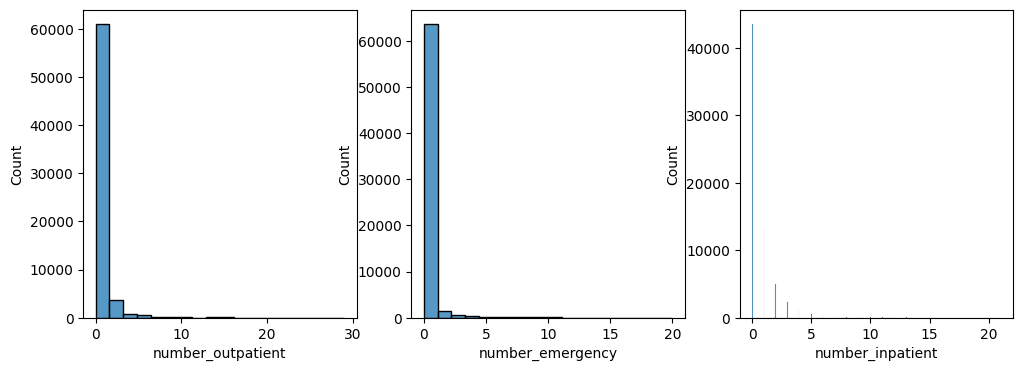

In [26]:
fig, ax = plt.subplots(1, 3, figsize=(12,4))

sns.histplot(twoRace['number_outpatient'], ax=ax[0], label='outpatient')
sns.histplot(twoRace['number_emergency'], ax=ax[1], label='emergency')
sns.histplot(twoRace['number_inpatient'], ax=ax[2], label='intpatient')

plt.show()


For all 3 variables, the majority of oberservations have 0 encounters.  These would be better suited as boolean categorical types indicating if the patient had that type of encounter in the previous year or not.  

In [27]:
twoRace['outpatientTF'] = twoRace.number_outpatient.astype(bool)
twoRace['emergencyTF'] = twoRace.number_emergency.astype(bool)
twoRace['patientTF'] = twoRace.number_inpatient.astype(bool)

twoRace = twoRace.drop(['number_outpatient','number_emergency','number_inpatient'], axis=1)

#### glucose measurements<a id="glu_meas"></a>

A1Cresult and max_glu_serum speak to how well the patient's diabetes is managed.  These could be interesting as well.

In [28]:
[f'{x}: {twoRace[x].mean()}' for x in ['outpatientTF','emergencyTF','patientTF']]

['outpatientTF: 0.16288410721026803',
 'emergencyTF: 0.11630049075122688',
 'patientTF: 0.34322385805964517']

In [29]:
print(twoRace.A1Cresult.astype('category').value_counts(), '\n\n')
print(twoRace.max_glu_serum.astype('category').value_counts())

None    55216
>8       5371
Norm     3269
>7       2369
Name: A1Cresult, dtype: int64 


None    62955
Norm     1612
>200      877
>300      781
Name: max_glu_serum, dtype: int64


These values were sparesely captured and categorized into broad categories.  Unfortunately, these will need to be dropped.

In [30]:
twoRace = twoRace.drop(['A1Cresult','max_glu_serum'], axis=1)

### numerical descriptions of admission <a id="num_"></a>

The next set of variables to explore are the different counts of occurences in during the initial admission.  These include time_in_hospital, num_lab_procedures, num_procedures, num_medications, and num_diagnoses.  At a high level, these describe the number of interventions performed during the admission.

In [31]:
encounter_attributes = twoRace[['time_in_hospital',
                                'num_lab_procedures',
                                'num_procedures',
                                'num_medications',
                                'number_diagnoses']].copy()

The Ydata profiling package will help to start this exploration by calculating the various statistics for each variable as well as their correlations.

In [32]:
profile = ydata_profiling.ProfileReport(encounter_attributes)
profile.to_widgets()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render widgets:   0%|          | 0/1 [00:00<?, ?it/s]

I will make notes on what to explore next for each variable individually.  I will define outliers as 75th perctile + 1.5 x the Interquartile range

<ul style="margin-bottom: 10px;">
    <li>time_in_hopsital</li>
    <ul>
        <li>there are no zeroes</li>
        <li>the distribution looks uniform</li>
        <li>there are potentially 2,123 outliers</li>
        <ul>
            <li>with the uniformity of the distribution and the relatively high volume, these will be left in place</li>
        </ul>
    </ul>
</ul>

<ul style="margin-bottom: 10px;">
    <li>num_lab_procedures</li>
    <ul>
        <li>there are no zeroes</li>
        <li>the distribution looks nearly normal, except for a long right tail and a large count of "1"s</li>
        <li>there are many outliers in the long right tail</li>
    </ul>
</ul>

<ul style="margin-bottom: 10px;">
    <li>num_procedures</li>
    <ul>
        <li>46% of the observations have a value of 0</li>
        <li>the distribution looks uniform</li>
        <li>by strict definition, there are 4,647 outliers</li>
        <ul>
            <li>the strict definition will be ignored here as any special handling of these would decrease the value of this variable</li>
        </ul>        
    </ul>
</ul>    
    
<ul style="margin-bottom: 10px;">
    <li>num_medications</li>
    <ul>
        <li>there are no zeroes</li>
        <li>the distribution looks nearly normal, except for the long right tail</li>
        <li>there are many outliers in the right tail</li>
    </ul>
</ul>  

<ul style="margin-bottom: 10px;">
    <li>number_diagnoses
    <ul>
        <li>there are no zeroes</li>
        <li>the distribution follows no pattern</li>
        <li>there are potentially 53 outliers</li>
        <ul>
            <li>the extreme amount of observations with the value of 9 likely has a large impact on the measures of center</li>
        </ul>        
    </ul>
</ul> 

#### time_in_hospital<a id="tih"></a>

This variable represents the number of days in a patient's admission.  Length of stay is a valuable metric for any hospital based analyses and the uniformity of the right tail in the histogram means it would be appropriate to leave any values deemed outliers by the Q3 + 1.5xIQR definition in place.

#### num_lab_procedures<a id="nlp"></a>

I will view this variable as a boxplot and a histogram.

In [33]:
def box_and_hist (array):

    fig, ax = plt.subplots(1, 2, figsize=(12,4))

    sns.boxplot(x=array, ax=ax[0], showfliers=True)
    sns.histplot(array, ax=ax[1])

    plt.show()
    
    return

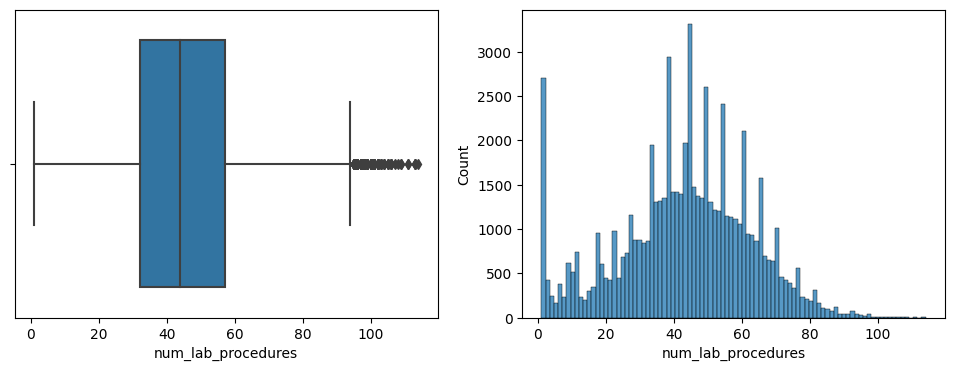

In [34]:
box_and_hist(twoRace['num_lab_procedures'])

These views verify the presence of the outliers and their potential impact on statistics.  By the Q3 + 1.5IQR rule, 96 would be the outlier boundary.  This looks appropriate with these visuals and it seems like there is little extra information to be learned from knowing if a patient had 96 or 120 lab procedures.  It would be appropriate to replace any value higher than 96 with a value of 96.

count    66225.000000
mean        43.197720
std         19.429817
min          1.000000
25%         32.000000
50%         44.000000
75%         57.000000
max         96.000000
Name: num_lab_procedures, dtype: float64


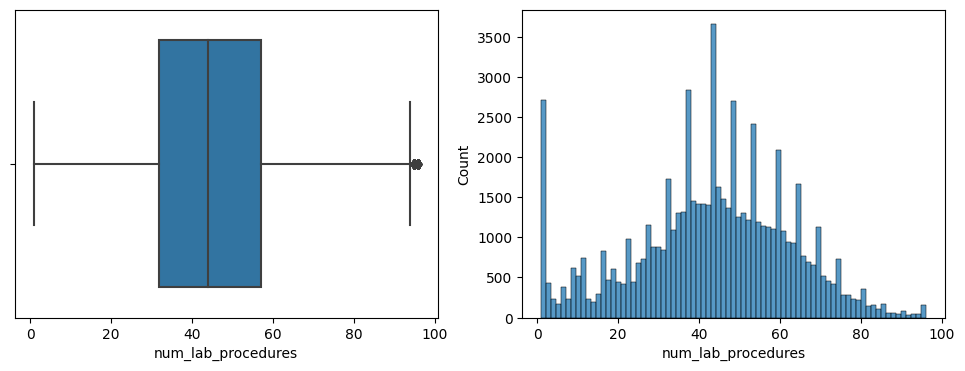

In [35]:
twoRace.loc[twoRace['num_lab_procedures'] > 96, 'num_lab_procedures'] = 96
print(twoRace.num_lab_procedures.describe())
box_and_hist(twoRace['num_lab_procedures'])

I have removed the outliers without any undue impact on the shape of this feature's distribution.

#### num_procedures<a id="np"></a>

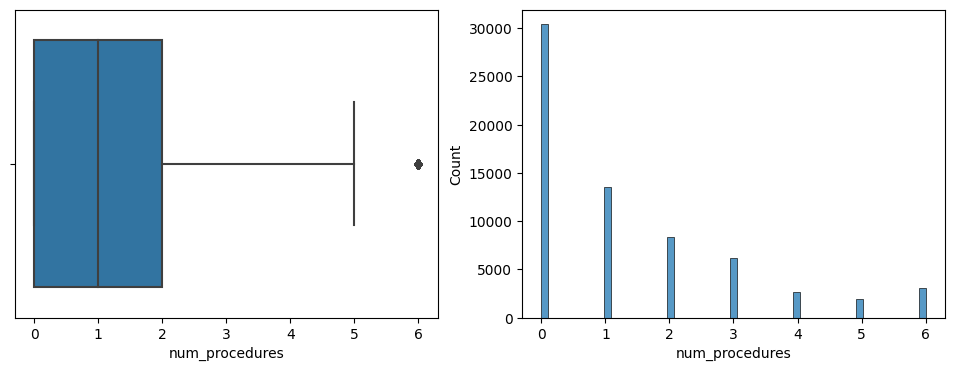

In [36]:
box_and_hist(twoRace['num_procedures'])

As expected, this variable should remain untouched.  The small range of values and uniformity should model well.

#### num_medications<a id="nm"></a>

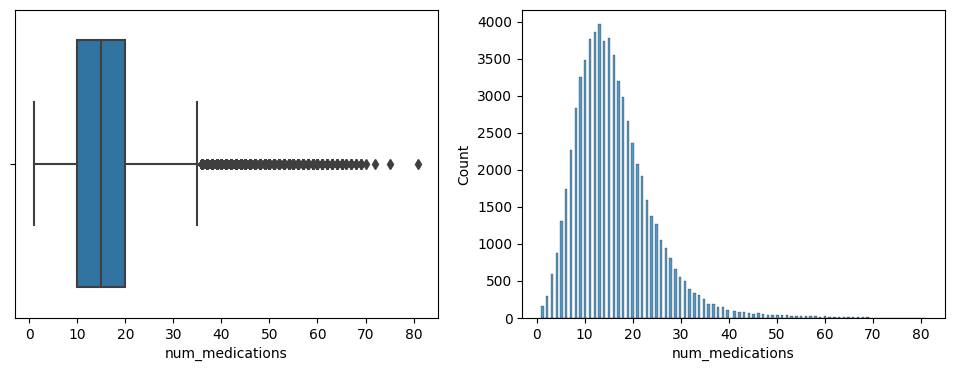

In [37]:
box_and_hist(twoRace['num_medications'])

There is a very long right tail after a fairly normal looking distribution here.  Would it be appropriate to pull all of the higher values down to the outer whisker?

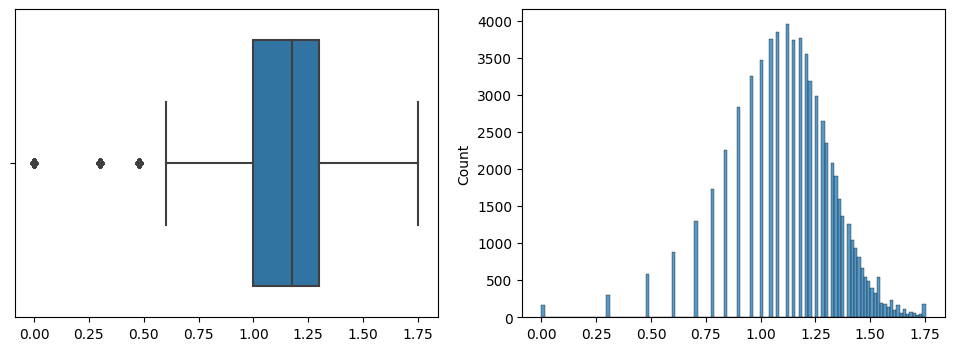

       num_medications
count     66225.000000
mean          1.148410
std           0.233058
min           0.000000
25%           1.000000
50%           1.176091
75%           1.301030
max           1.908485
                  0
count  66225.000000
mean       1.148344
std        0.232880
min        0.000000
25%        1.000000
50%        1.176091
75%        1.301030
max        1.752575


In [48]:
def iqr_test(data):

    outer_whisker = np.percentile(data, 75) + 1.5 * (np.percentile(data, 75) - np.percentile(data, 25))
    outliers_to_whisker = np.where(data > outer_whisker, outer_whisker, data)
    box_and_hist(outliers_to_whisker)
    print(pd.DataFrame(data).describe())
    print(pd.DataFrame(outliers_to_whisker).describe())
    
iqr_test(twoRace.num_medications)

It looks like this could be appropriate, but would a log transformation be better?

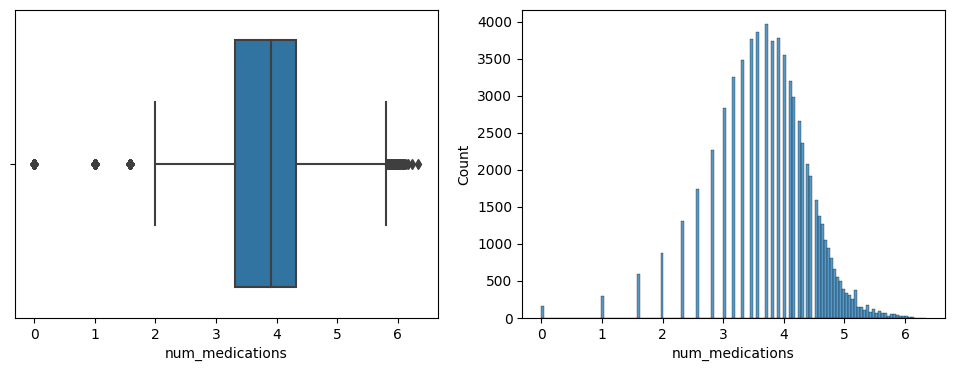

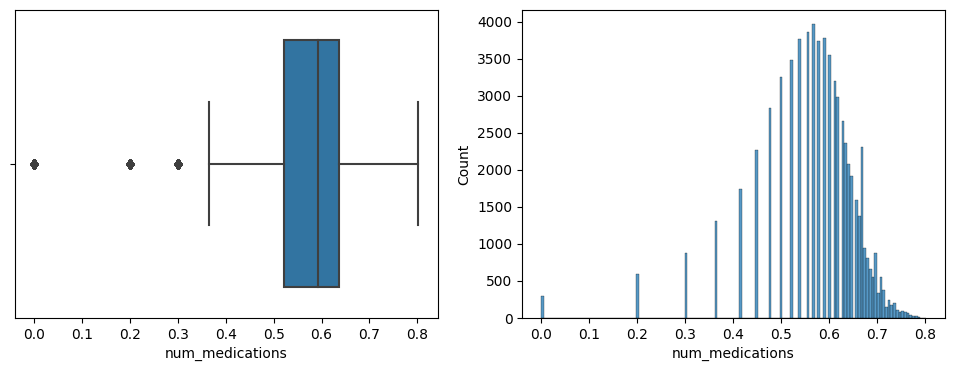

In [39]:
log_transform = twoRace['num_medications'].copy()
log_transform = np.log2(log_transform)
box_and_hist(log_transform)
log_transform = np.log10(log_transform)
box_and_hist(log_transform)

The log10 transformation results in a more uniform distribution with fewer outliers and seems like the best way to handle the long right tail of num_medications.

In [40]:
twoRace['num_medications'] = np.log10(twoRace['num_medications'])

#### number_diagnoses<a id="nd"></a>

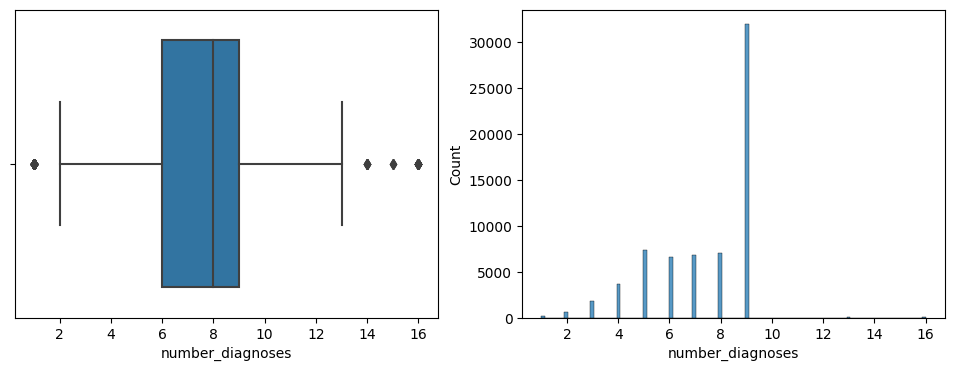

In [41]:
box_and_hist(twoRace['number_diagnoses'])

There is something interesting happening at 9.  It seems like it could be a data collection issue where most facilities only keep 9 diagnoses for an admission while a small number of other facilities allow more.  It could also be that a common type of admission among diabetics has a diagnoses set that includes 9 different codes.  If the second option is true, the diag_1, 2 and 3 variables should have common values for many of the observations with 9. 

In [42]:
nines = twoRace['number_diagnoses'] == 9

only_9_dx = twoRace.loc[nines, ['diag_1','diag_2','diag_3']]
only_9_dx.value_counts().sort_values(ascending=False).head(10)

diag_1  diag_2  diag_3
414     411     428       74
584     276     276       63
414     411     427       51
428     425     427       48
414     411     250       44
410     428     427       41
38      599     276       40
486     491     428       38
414     411     401       38
428     403     585       37
dtype: int64

The 400 series codes are heart disase codes, 500s are kidney disease and 276 is a fluid imbalance, commonly seen with kidney disorders.  This has somewhat validated the theory that the 9s could be saved codesets, but this needs to be compared to the full dataset to verify.

In [43]:
twoRace[['diag_1','diag_2','diag_3']].value_counts().sort_values(ascending=False).head(10)

diag_1  diag_2  diag_3
414     411     250       216
                401       168
786     401     250       168
        250     401       158
410     414     250       143
715     401     250       136
414     401     250       118
715     250     401       116
414     250     401       114
        411     428       109
dtype: int64

At a glance, the top 3 diagnoses of the oberservations with 9 diagnoses are much different than the full set.  This lends more weight to the idea that they are saved codesets.  Are these top 3 diagnoses similar for observations that have 9 total diagnoses and more than 9?

In [44]:
more_than_nine = twoRace['number_diagnoses'] > 9
more_than_nine = twoRace.loc[more_than_nine, ['diag_1','diag_2','diag_3']]
more_than_nine.value_counts().sort_values(ascending=False).head(10)

diag_1  diag_2  diag_3
157     415     199       1
403     585     250.8     1
250.4   425     276       1
250.8   458     V08       1
        518     707       1
250.82  707     682       1
276     486     599       1
        584     562       1
        785     585       1
283     574     250.02    1
dtype: int64

No, every observation with more than 9 diagnoses has different values for diagnoses 1-3.  What does this distribution look like if we apply the q3 + 1.5iqr rule to it?

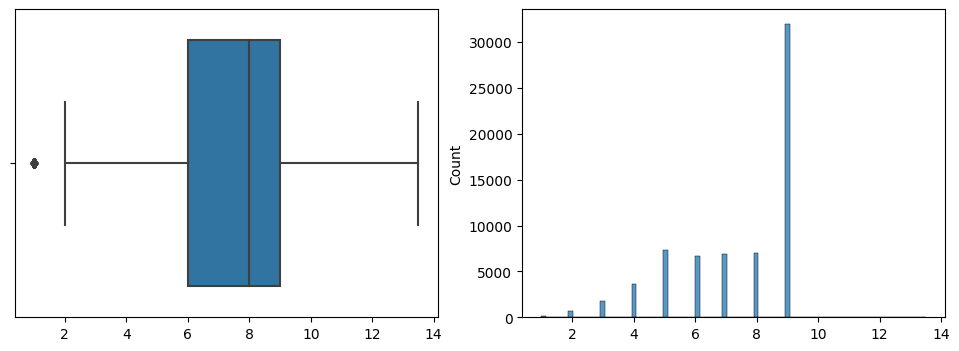

       number_diagnoses
count      66225.000000
mean           7.420385
std            1.925318
min            1.000000
25%            6.000000
50%            8.000000
75%            9.000000
max           16.000000
                  0
count  66225.000000
mean       7.419434
std        1.921738
min        1.000000
25%        6.000000
50%        8.000000
75%        9.000000
max       13.500000


In [49]:
iqr_test(twoRace.number_diagnoses)

This seems like an acceptable handle to handle these outliers.

In [50]:
outer_whisker = np.percentile( twoRace.number_diagnoses, 75) + 1.5 * (np.percentile( twoRace.number_diagnoses, 75) - np.percentile( twoRace.number_diagnoses, 25))
twoRace.number_diagnoses = np.where(twoRace.number_diagnoses > outer_whisker, outer_whisker, twoRace.number_diagnoses)

In [52]:
twoRace.dtypes

patient_nbr               int64
race                     object
gender                   object
age                    category
admission_type_id      category
admission_source_id    category
time_in_hospital          int64
num_lab_procedures        int64
num_procedures            int64
num_medications         float64
diag_1                   object
diag_2                   object
diag_3                   object
number_diagnoses        float64
metformin                object
repaglinide              object
nateglinide              object
chlorpropamide           object
glimepiride              object
glipizide                object
glyburide                object
tolbutamide              object
pioglitazone             object
rosiglitazone            object
acarbose                 object
miglitol                 object
tolazamide               object
insulin                  object
glyburide-metformin      object
change                   object
diabetesMed              object
readmitt